# Mô tả bài toán: Linear Regression

## Xây dựng mô hình tuyến tính $$y = f(x) = X*\theta$$

Trong đó : 
- $y$ là biến phụ thuộc (vector kích thước $N x 1$ với $N$ là số lượng mẫu)
- $X$ là biến độc lập (ma trận kích thước $N x D$ với $N$ là số lượng mẫu và $D$ là số features)
- $\theta$ là tham số của mô hình (vector kích thước $D x 1$)

## Performance của mô hình

Performance của mô hình được đo lường bởi trung bình bình phương sai số của mô hình, cụ thể:

$$L = \frac{1}{N}\sum_{i=1}^N (y_i - f(x_i))^2 = \frac{1}{N}||y - X\theta||_2^2 = \frac{1}{N}(y - X\theta)^T(y - X\theta)$$ 

Giá trị sai số L càng nhỏ thì performance của mô hình càng tốt

## Xây dựng bài toán tối ưu



$$\theta = argmin_{\theta} L = argmin_{\theta}\frac{1}{N}(y - X\theta)^T(y - X\theta) $$

Ta sẽ sử dụng thuật toán Gradient Descent và Accelerated Gradient Descent để tìm nghiệm tối ưu cho bài toán

Trước hết cần xác định công thức tính gradient của $L$ theo $\theta$

Có $$\nabla_{\theta} L = \nabla_{\theta} \frac{1}{N}(y - X\theta)^T(y - X\theta) = \frac{-2}{N}X^T(y-X\theta)$$


## Implement mô hình

In [92]:
## X: N x D matrix
## y: N x 1 matrix
## beta: D x 1 matrix
import numpy as np
from datetime import datetime

def compute_loss(X, y, beta):
    y_pred = X.dot(beta)
    loss = ((y_pred - y)**2).mean()
    return loss

def compute_gradient(X, y, beta):
    N = X.shape[0]
    grad = 2/N * X.T.dot(X.dot(beta) - y)
    return grad

In [103]:

def gd_optimizer(X, y, num_steps, learning_rate, show_progress = False):
    start_time = datetime.now()
    converged = False
    losses = []
    threshold = 1e-6
    beta = np.zeros((X_normalized.shape[1],1))
    for step in range(num_steps):
        loss = compute_loss(X, y, beta)
        losses.append(loss)
        if len(losses) > 1:
            if losses[-2] - losses[-1] < threshold and not converged:
                print(f'Converge after {step} steps, running time: {datetime.now() - start_time}')
                converged = True
        grad = compute_gradient(X, y, beta)
        beta = beta - learning_rate * grad
            
        if step %1000 == 0 and show_progress:
            print('*'*50)
            print("Step", step, "Loss value", loss)
    if not converged:
        print(f'Not converge after {num_steps}, running time: {datetime.now() - start_time}')
    return losses, beta


def backtracking_gd(X, y, beta):
    lr = 1
    rho = 0.8
    c1 = 1e-3
    grad = compute_gradient(X, y, beta)
    while compute_loss(X, y, beta - lr * grad) > compute_loss(X, y, beta) - c1 * lr * grad.T.dot(grad):
        lr = rho * lr
    return lr


def gd_optimizer_backtracking(X, y, num_steps, show_progress = False):
    start_time = datetime.now()
    losses = []
    lrs = []
    threshold = 1e-6
    beta = np.zeros((X_normalized.shape[1],1))
    converged = False
    for step in range(num_steps):
        loss = compute_loss(X, y, beta)
        losses.append(loss)
        if len(losses) > 1:
            if losses[-2] - losses[-1] < threshold and not converged:
                converged = True
                print(f'Converge after {step} steps, running time: {datetime.now() - start_time}')
        grad = compute_gradient(X, y, beta)
        learning_rate = backtracking_gd(X, y, beta)
        
        beta = beta - learning_rate * grad
        
        lrs.append(learning_rate)
        
        if step %1000 == 0 and show_progress:
            print('*'*50)
            print("Step", step, "Loss value", loss)
    if not converged:
        print(f'Not converge after {num_steps}, running time: {datetime.now() - start_time}')

    return losses, beta, lrs

In [106]:
def accelerated_gd_optimizer(X, y, num_steps, learning_rate, show_progress = False):
    start_time = datetime.now()
    losses = []
    beta = np.zeros((X_normalized.shape[1],1))
    threshold = 1e-6
    converged = False
    for step in range(num_steps):
        loss = compute_loss(X_normalized, y, beta)
        losses.append(loss)
        if step == 0:
            grad = compute_gradient(X_normalized, y, beta)
            last_beta = beta
            beta = beta - learning_rate * grad
        else:
            if len(losses) > 1:
                if losses[-2] - losses[-1] < threshold and not converged:
                    converged = True
                    print(f'Converge after {step} steps, running time: {datetime.now() - start_time}')
            v = beta + (step-1)/(step+2) * (beta - last_beta)
            last_beta = beta
            grad = compute_gradient(X_normalized, y, v) 
            beta = v - learning_rate * grad
            
        if step %1000 == 0 and show_progress:
            print('*'*50)
            print("Step", step, "Loss value", loss)

    if not converged:
        print(f'Not converge after {num_steps}, running time: {datetime.now() - start_time}')

    return losses, beta


def backtracking_accelerated_gd(X, y, beta, last_lr):
    lr = last_lr
    rho = 0.8
    c1 = 1e-3
    grad = compute_gradient(X, y, beta)
    while compute_loss(X, y, beta - lr * grad) > compute_loss(X, y, beta) -  lr * grad.T.dot(grad) + 1/(2*lr)* lr**2 * grad.T.dot(grad):
        lr = rho * lr
    return lr


def accelerated_gd_optimizer_backtracking(X, y, num_steps, show_progress = False):
    start_time = datetime.now()
    losses = []
    lr = 1
    lrs = []
    threshold = 1e-6
    beta = np.zeros((X_normalized.shape[1],1))
    converged = False
    for step in range(num_steps):
        loss = compute_loss(X_normalized, y, beta)
        losses.append(loss)
        if step == 0:
            grad = compute_gradient(X_normalized, y, beta)
            last_beta = beta
            lr = backtracking_accelerated_gd(X, y, beta, lr)
            beta = beta - lr * grad
        else:
            if len(losses) > 1:
                if losses[-2] - losses[-1] < threshold and not converged:
                    print(f'Converge after {step} steps, running time: {datetime.now() - start_time}')
                    converged = True
            v = beta + (step-1)/(step+2) * (beta - last_beta)
            last_beta = beta
            grad = compute_gradient(X_normalized, y, v)
            lr = backtracking_accelerated_gd(X, y, beta, lr)
            beta = v - lr * grad     
        
        lrs.append(lr)
        if step %1000 == 0 and show_progress:
            print('*'*50)
            print("Step", step, "Loss value", loss)
    if not converged:
        print(f'Not converge after {num_steps}, running time: {datetime.now() - start_time}')

    return losses, beta, lrs


    

In [98]:
import pandas as pd

import numpy as np
train_data = pd.read_csv("./boston-housing/train.csv")

In [99]:
train_data.head()

,ID,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
3,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
4,7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9


In [100]:
## Get first 13 columns as X
X = train_data.values[:,1:-1]

## Normalize X
mean = X.mean(axis = 0)
std = X.std(axis = 0)
X_normalized = (X - mean)/std
X_normalized = np.c_[np.ones(X.shape[0]), X_normalized]
## Get last columns as y
y = train_data.values[:,-1].reshape((X.shape[0],1))

In [109]:
print("Accelerated Gradient Descent w. backtracking")
acc_gd_backtracking_losses, acc_gd_backtracking_beta, acc_gd_backtracking_lrs = accelerated_gd_optimizer_backtracking(X_normalized, y, 2000)
print("*" * 50,'\n')
print("Gradient Descent w. backtracking")
gd_backtracking_losses, gd_backtracking_beta, gd_backtracking_lrs = gd_optimizer_backtracking(X_normalized, y, 2000)
print("*" * 50,'\n')
print("Accelerated Gradient Descent lr = 0.001")
acc_gd_losses_001, acc_gd_beta_001 = accelerated_gd_optimizer(X, y, 2000, 0.001)
print("*" * 50,'\n')
print("Gradient Descent lr = 0.001")
gd_losses_001, gd_beta_001 = gd_optimizer(X_normalized, y, 2000, 0.001)    
print("*" * 50,'\n')
print("Accelerated Gradient Descent lr = 0.01")
acc_gd_losses_01, acc_gd_beta_01 = accelerated_gd_optimizer(X, y, 2000, 0.01)
print("*" * 50,'\n')
print("Gradient Descent lr = 0.01")
gd_losses_01, gd_beta_01 = gd_optimizer(X_normalized, y, 2000, 0.01)    
print("*" * 50,'\n')
print("Accelerated Gradient Descent lr = 0.1")
acc_gd_losses_1, acc_gd_beta_1 = accelerated_gd_optimizer(X, y, 2000, 0.1)
print("*" * 50,'\n')
print("Gradient Descent lr = 0.1")
gd_losses_1, gd_beta_1 = gd_optimizer(X_normalized, y, 2000, 0.1)    


Accelerated Gradient Descent w. backtracking
Converge after 10 steps, running time: 0:00:00.001877
************************************************** 

Gradient Descent w. backtracking
Converge after 183 steps, running time: 0:00:00.082868
************************************************** 

Accelerated Gradient Descent lr = 0.001
Converge after 87 steps, running time: 0:00:00.003096
************************************************** 

Gradient Descent lr = 0.001
Not converge after 2000, running time: 0:00:00.063353
************************************************** 

Accelerated Gradient Descent lr = 0.01
Converge after 28 steps, running time: 0:00:00.001538
************************************************** 

Gradient Descent lr = 0.01
Not converge after 2000, running time: 0:00:00.054323
************************************************** 

Accelerated Gradient Descent lr = 0.1
Converge after 9 steps, running time: 0:00:00.001137
************************************************** 

G

In [110]:
history_df = pd.DataFrame()

history_df['GD backtracking'] = gd_backtracking_losses
history_df['Acc GD backtracking'] = acc_gd_backtracking_losses

history_df['GD lr 0.001'] = gd_losses_001
history_df['Acc GD lr 0.001'] = acc_gd_losses_001

history_df['GD lr 0.01'] = gd_losses_01
history_df['Acc GD lr 0.01'] = acc_gd_losses_01

history_df['GD lr 0.1'] = gd_losses_1
history_df['Acc GD lr 0.1'] = acc_gd_losses_1

history_df['GD lr'] = gd_backtracking_lrs
history_df['Acc GD lr'] = acc_gd_backtracking_lrs



In [111]:
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(True)
import cufflinks


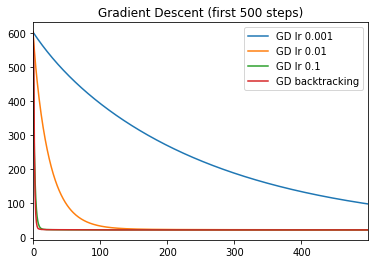

In [112]:
history_df[['GD lr 0.001', 'GD lr 0.01', 'GD lr 0.1', 'GD backtracking']].iloc[:500].plot( title = 'Gradient Descent (first 500 steps)')

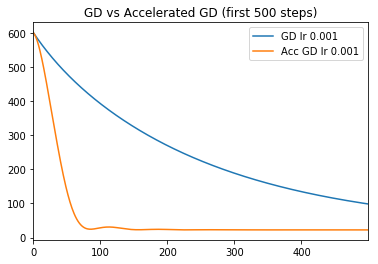

In [113]:
history_df[['GD lr 0.001', 'Acc GD lr 0.001']].iloc[:500].plot( title = 'GD vs Accelerated GD (first 500 steps)')

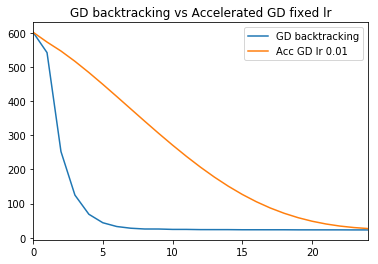

In [115]:
history_df[['GD backtracking', 'Acc GD lr 0.01']].iloc[:25].plot( title = 'GD backtracking vs Accelerated GD fixed lr')

In [68]:
iplot(history_df.iplot(asFigure = True))